# lib

In [1]:
import pickle
# import warnings
# warnings.filterwarnings('ignore')
# import os
# import pandas as pd
import numpy as np
# import math
# import datetime as dt
import matplotlib.pyplot as plt

# from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score 
# from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score
# from sklearn.preprocessing import MinMaxScaler , StandardScaler

# from itertools import product
# import statsmodels.api as sm

import tensorflow as tf

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Input, ConvLSTM1D, Conv1D, Concatenate, Bidirectional
from tensorflow.keras.layers import LSTM , BatchNormalization, AveragePooling1D, Flatten, GRU, SimpleRNN

# from itertools import cycle
import plotly.offline as py
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

plt.style.use('seaborn-darkgrid')

# creat data lstm

In [2]:
with open('btc.moh','rb') as f :
    btc = pickle.load(f)

In [3]:
'''
x norm Tanh estimators
𝑥𝑛𝑜𝑟𝑚 = 0.5 [𝑡𝑎𝑛ℎ [0.01(𝑥 − 𝜇)𝛿] + 1] 
'''
def Tanh_estimators(x):
    return ( 0.5 * ( ( np.tanh( ( 0.01 * ( x - m ) ) / s ) ) + 1 ) )

def Tanh_estimators_invers(x):
    return ( ( ( (np.arctanh( x * 2 - 1 ) )  * s ) / 0.01 ) + m )

In [4]:
# std
s = np.std(btc.close)
m = np.mean(btc.close)

btc.close = btc.close.map(Tanh_estimators)

s = np.std(btc.target)
m = np.mean(btc.target)

btc.target = btc.target.map(Tanh_estimators)



s = np.std(btc.close_log)
m = np.mean(btc.close_log)

btc.close_log = btc.close_log.map(Tanh_estimators)

s = np.std(btc.target_log)
m = np.mean(btc.target_log)

btc.target_log = btc.target_log.map(Tanh_estimators)

In [5]:
look_back_ = 90
prediction_days = 60
future_ = 30


df_train_= btc[:][:len(btc)-(prediction_days+future_)]#values.reshape(-1,1)

df_test_= btc[:][len(btc)-(prediction_days+future_+look_back_-1):len(btc)-future_]#.values.reshape(-1,1)

future_ = btc[:][len(btc)-(future_+look_back_-1):]

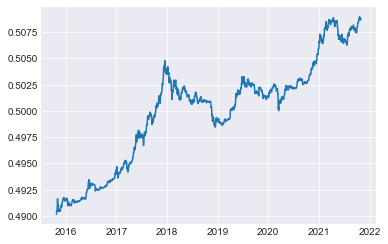

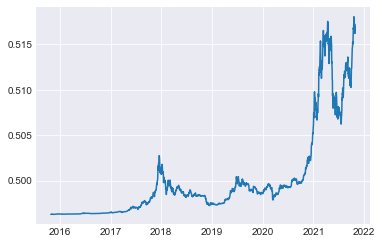

In [6]:
plt.plot(btc.close_log)
plt.figure()
plt.plot(btc.close)

In [7]:
df_train_.columns

Index(['close_log', 'close', 'target_log', 'target'], dtype='object')

In [8]:
col = ['close_log', 'close', 'target_log', 'target']
df_train = df_train_[:][col]
df_test = df_test_[:][col]
future = future_[:][col]
df_test.head(2)

,close_log,close,target_log,target
date,,,,
2021-05-04,0.508414,0.514784,0.508445,0.514943
2021-05-05,0.508452,0.514990,0.508512,0.515304


In [9]:
# # many to one

# from collections import deque
# def dataset_generator_lstm(dataset, look_back=look_back_):
#   sequential_data = [] 
#   prev_days = deque(maxlen=look_back)
#   for i in dataset.values:
#     prev_days.append([n for n in i[:-1]])
#     if len(prev_days) == look_back:  
#       sequential_data.append([np.array(prev_days), i[-1]])
#   dataX=[]
#   dataY=[]
#   for seq, target in sequential_data: 
#     dataX.append(seq) 
#     dataY.append(target) 
#   return np.array(dataX), np.array(dataY)

# trainX, trainY = dataset_generator_lstm(df_train)

# testX, testY = dataset_generator_lstm(df_test)
# # trainX, trainY = trainX[:1740], trainY[:1740]

# futureX, futureY = dataset_generator_lstm(future)

# print("trainX: ", trainX.shape)
# print("trainY: ", trainY.shape)
# print("testX: ", testX.shape)
# print("testY", testY.shape)
# print("futureX: ", futureX.shape)
# print("futureY", futureY.shape)

In [10]:
# one to one

from collections import deque
def dataset_generator_lstm(dataset, look_back=look_back_):
    sequential_data = [] 
    sequential_data_log = [] 
    prev_days = deque(maxlen=look_back)
    prev_days_log = deque(maxlen=look_back)

    for i in dataset.values:
        prev_days_log.append(i[0])
        prev_days.append(i[1])

        if len(prev_days) == look_back:  
            sequential_data_log.append([np.array(prev_days), i[-1]])
            sequential_data.append([np.array(prev_days), i[-2]])
      
      
    dataX_log=[]
    dataY_log=[]

    dataX=[]
    dataY=[]

    for seq, target in sequential_data_log: 
        dataX_log.append(seq) 
        dataY_log.append(target) 

    for seq, target in sequential_data: 
        dataX.append(seq) 
        dataY.append(target) 

    dataX_log = tf.expand_dims(dataX_log,axis=2)
    dataX = tf.expand_dims(dataX,axis=2)

    return np.array(dataX_log), np.array(dataY_log), np.array(dataX), np.array(dataY)

trainX_log, trainY_log, trainX, trainY = dataset_generator_lstm(df_train)

testX_log, testY_log, testX, testY = dataset_generator_lstm(df_test)
# trainX, trainY = trainX[:1740], trainY[:1740]

futureX_log, futureY_log, futureX, futureY = dataset_generator_lstm(future)

print("trainX: ", trainX.shape)
print("trainY: ", trainY.shape)
print("trainX_log: ", trainX_log.shape)
print("trainY_log: ", trainY_log.shape)
print("testX: ", testX.shape)
print("testY", testY.shape)
print("testX_log: ", testX_log.shape)
print("testY_log", testY_log.shape)
print("futureX: ", futureX.shape)
print("futureY", futureY.shape)
print("futureX_log: ", futureX_log.shape)
print("futureY_log", futureY_log.shape)

trainX:  (2016, 90, 1)
trainY:  (2016,)
trainX_log:  (2016, 90, 1)
trainY_log:  (2016,)
testX:  (60, 90, 1)
testY (60,)
testX_log:  (60, 90, 1)
testY_log (60,)
futureX:  (30, 90, 1)
futureY (30,)
futureX_log:  (30, 90, 1)
futureY_log (30,)


# train

In [11]:
# batch_size = 60

# regressor = Sequential()

# regressor.add(LSTM(units = 256, activation = 'relu', return_sequences=True, batch_input_shape = (batch_size, trainX.shape[1], trainX.shape[2]), stateful=True)) #  dropout=0.25, recurrent_dropout=0.1,
# regressor.add(Dropout(0.2))

# regressor.add(LSTM(units = 512, activation = 'relu', return_sequences=True, batch_input_shape = (batch_size, trainX.shape[1], trainX.shape[2]), stateful=True)) #  dropout=0.25, recurrent_dropout=0.1,
# regressor.add(Dropout(0.3))

# regressor.add(LSTM(units = 1024, activation = 'relu', return_sequences=True, batch_input_shape = (batch_size, trainX.shape[1], trainX.shape[2]), stateful=True)) #  dropout=0.25, recurrent_dropout=0.1,
# regressor.add(Dropout(0.4))

# regressor.add(LSTM(units = 128, activation = 'relu', batch_input_shape = (batch_size, trainX.shape[1], trainX.shape[2]), stateful=True))
# regressor.add(Dropout(0.2))


# regressor.add(Dense(units = 32, activation = 'relu'))
# regressor.add(Dropout(0.3))

# regressor.add(Dense(units = 1))

input1 = Input(shape=trainX_log.shape[1:])

conv11 = Conv1D(filters=30,kernel_size=30,padding="same",activation="relu")(input1)
conv12 = Conv1D(filters=60,kernel_size=14,padding="same",activation="relu")(input1)
conv13 = Conv1D(filters=90,kernel_size=7,padding="same",activation="relu")(input1)

conv1 = Concatenate(axis=2)([conv11, conv12, conv13])

pool1 = AveragePooling1D(pool_size=61, strides=1, padding="valid", data_format="channels_last")(conv1)

norm1 = BatchNormalization()(pool1)
drop1 = Dropout(rate=0.3)(norm1)

conv21 = Conv1D(filters=90,kernel_size=21,padding="same",activation="relu")(drop1)
conv22 = Conv1D(filters=180,kernel_size=14,padding="same",activation="relu")(drop1)
conv23 = Conv1D(filters=270,kernel_size=7,padding="same",activation="relu")(drop1)

conv2 = Concatenate(axis=2)([conv21, conv22, conv23])

pool2 = AveragePooling1D(pool_size=16, strides=1, padding="valid", data_format="channels_last")(conv2)

norm2 = BatchNormalization()(pool2)
drop2 = Dropout(rate=0.3)(norm2)

conv31 = Conv1D(filters=270,kernel_size=21,padding="same",activation="relu")(drop2)
conv32 = Conv1D(filters=360,kernel_size=14,padding="same",activation="relu")(drop2)
conv33 = Conv1D(filters=450,kernel_size=7,padding="same",activation="relu")(drop2)

conv3 = Concatenate(axis=2)([conv31, conv32, conv33])

pool3 = AveragePooling1D(pool_size=9, strides=1, padding="valid", data_format="channels_last")(conv3)

norm3 = BatchNormalization()(pool3)
drop3 = Dropout(rate=0.3)(norm3)

lstm1 = LSTM(units = 512, activation = 'relu', return_sequences=True)(drop3)

lstm2 = LSTM(units = 256, activation = 'relu', return_sequences=True)(lstm1)

lstm3 = LSTM(units = 512, activation = 'relu', return_sequences=True)(lstm2)

lstm4 = LSTM(units = 256, activation = 'relu', return_sequences=True)(lstm3)

lstm5 = LSTM(units = 512, activation = 'relu', return_sequences=True)(lstm4)

flatten = Flatten()(lstm5)
norm4 = BatchNormalization()(flatten)
drop4 = Dropout(rate=0.3)(norm4)

dense1 = Dense(units = 256, activation='relu')(drop4)

norm5 = BatchNormalization()(dense1)
drop5 = Dropout(rate=0.3)(norm5)

dense2 = Dense(units = 64, activation='relu')(drop5)

norm5 = BatchNormalization()(dense2)
drop5 = Dropout(rate=0.2)(norm5)

dense3 = Dense(units = 32, activation='relu')(drop5)

norm6 = BatchNormalization()(dense3)
drop6 = Dropout(rate=0.2)(norm6)

output = Dense(units = 1)(drop6)

model = Model(inputs=input1, outputs=output)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 90, 1)]      0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 90, 30)       930         ['input_1[0][0]']                
                                                                                                  
 conv1d_1 (Conv1D)              (None, 90, 60)       900         ['input_1[0][0]']                
                                                                                                  
 conv1d_2 (Conv1D)              (None, 90, 90)       720         ['input_1[0][0]']                
                                                                                              

 dense_1 (Dense)                (None, 64)           16448       ['dropout_4[0][0]']              
                                                                                                  
 batch_normalization_5 (BatchNo  (None, 64)          256         ['dense_1[0][0]']                
 rmalization)                                                                                     
                                                                                                  
 dropout_5 (Dropout)            (None, 64)           0           ['batch_normalization_5[0][0]']  
                                                                                                  
 dense_2 (Dense)                (None, 32)           2080        ['dropout_5[0][0]']              
                                                                                                  
 batch_normalization_6 (BatchNo  (None, 32)          128         ['dense_2[0][0]']                
 rmalizati

In [15]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau


model.compile(optimizer=tf.keras.optimizers.SGD(), loss = 'mean_squared_error')


earlystopping = EarlyStopping(monitor='loss', patience=500, restore_best_weights=True)



In [ ]:
from tensorflow.keras.models import load_model

model = load_model('my_best_model_v07.hdf5')

In [14]:
batch_size = 1024

rlrop = ReduceLROnPlateau(monitor='accuracy', patience=300, factor=0.2, min_lr=0.001)
checkpoint_full = ModelCheckpoint(filepath='my_best_model_v07.hdf5', monitor='loss', verbose=1, save_best_only=True, mode='min')
callbacks = [checkpoint_full, earlystopping, rlrop]

history_full = model.fit(trainX_log, trainY_log, batch_size = batch_size, epochs = 100000000, verbose=1, shuffle=False, validation_data=(testX_log, testY_log), callbacks=callbacks)

# checkpoint365 = ModelCheckpoint(filepath='my_best_model_365.hdf5', monitor='loss', verbose=1, save_best_only=True, mode='min')
# callbacks = [checkpoint365, earlystopping]
# history365 = regressor.fit(trainX[(len(trainY)-365):], trainY[(len(trainY)-365):], batch_size = batch_size, epochs = 50000, verbose=1, shuffle=False, validation_data=(testX, testY), callbacks=callbacks)

NameError: name 'ReduceLROnPlateau' is not defined

In [25]:
plt.figure(figsize=(16,7))
plt.plot(history_full.history['loss'], label='train')

plt.plot(history_full.history['val_loss'], label='test')
plt.legend()
plt.show()

NameError: name 'history_full' is not defined

<Figure size 1152x504 with 0 Axes>

In [56]:
from tensorflow.keras.models import load_model

model_from_saved_checkpoint = load_model('my_best_model_v07.hdf5')

# test test

In [13]:
# batch_size = 1


# model_from_saved_checkpoint = Sequential()


# model_from_saved_checkpoint.add(LSTM(units = 256, activation = 'relu', return_sequences=True, batch_input_shape = (batch_size, trainX.shape[1], trainX.shape[2]), stateful=True)) #  dropout=0.25, recurrent_dropout=0.1,
# model_from_saved_checkpoint.add(Dropout(0.2))

# model_from_saved_checkpoint.add(LSTM(units = 512, activation = 'relu', return_sequences=True, batch_input_shape = (batch_size, trainX.shape[1], trainX.shape[2]), stateful=True)) #  dropout=0.25, recurrent_dropout=0.1,
# model_from_saved_checkpoint.add(Dropout(0.3))

# model_from_saved_checkpoint.add(LSTM(units = 1024, activation = 'relu', return_sequences=True, batch_input_shape = (batch_size, trainX.shape[1], trainX.shape[2]), stateful=True)) #  dropout=0.25, recurrent_dropout=0.1,
# model_from_saved_checkpoint.add(Dropout(0.4))

# model_from_saved_checkpoint.add(LSTM(units = 128, activation = 'relu', batch_input_shape = (batch_size, trainX.shape[1], trainX.shape[2]), stateful=True))
# model_from_saved_checkpoint.add(Dropout(0.2))


# model_from_saved_checkpoint.add(Dense(units = 32, activation = 'relu'))
# model_from_saved_checkpoint.add(Dropout(0.3))

# model_from_saved_checkpoint.add(Dense(units = 1))


# model_from_saved_checkpoint.load_weights('my_best_model_full.hdf5')
    
# model_from_saved_checkpoint.summary()



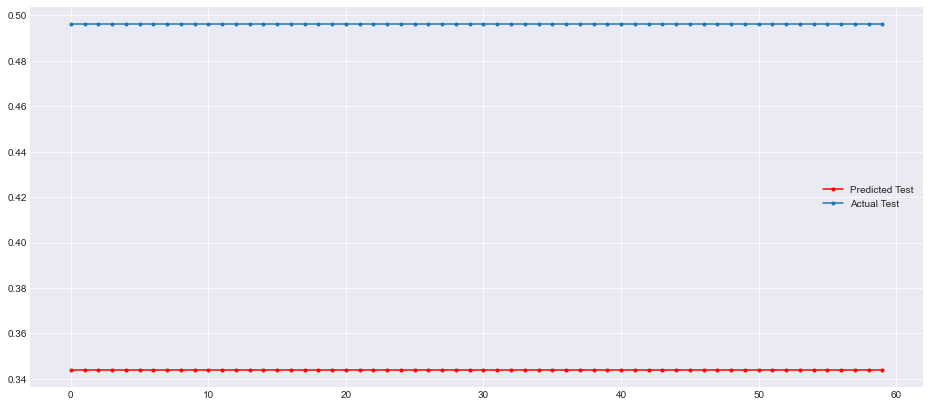

In [58]:
plt.figure(figsize=(16,7))

# log
predicted_btc_price_test_data = model_from_saved_checkpoint.predict(testX)
predicted_btc_price_test_data = np.array(predicted_btc_price_test_data)
test_actual = testY

plt.plot(predicted_btc_price_test_data, 'r', marker='.', label='Predicted Test')
plt.plot(test_actual, marker='.', label='Actual Test')

# # manoal
# predicted_btc_price_test_data = model_from_saved_checkpoint.predict(testX)
# predicted_btc_price_test_data = scaler_t.inverse_transform(predicted_btc_price_test_data.reshape(-1, 1))
# test_actual = scaler_t.inverse_transform(testY.reshape(-1, 1))

# plt.plot(predicted_btc_price_test_data, 'r', marker='.', label='Predicted Test')
# plt.plot(test_actual, marker='.', label='Actual Test')


plt.legend()
plt.show()

# test train

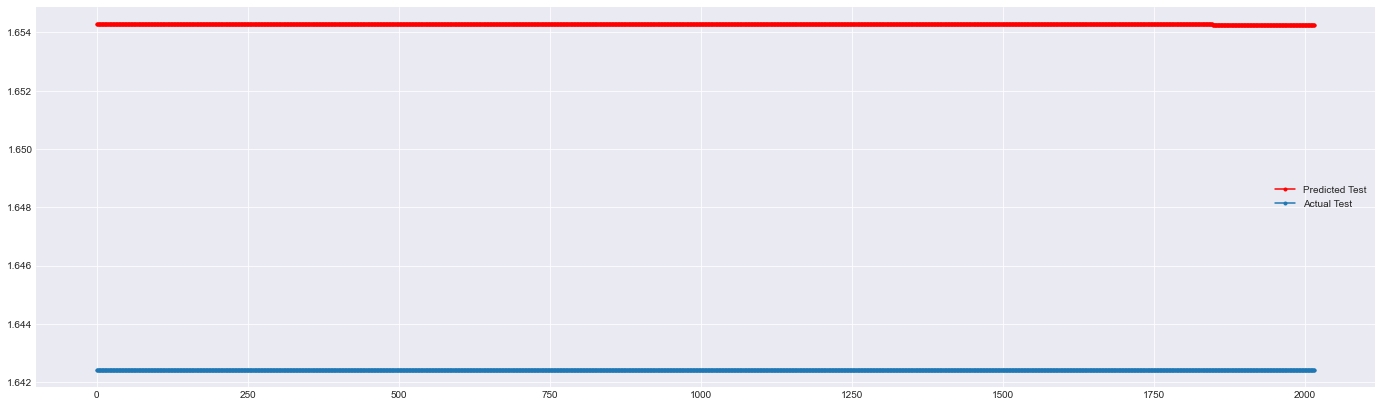

In [29]:
plt.figure(figsize=(24,7))

# log
predicted_btc_price_train_data = model_from_saved_checkpoint.predict(trainX)
predicted_btc_price_train_data = np.array(predicted_btc_price_train_data).reshape(-1, 1)
train_actual = trainY.reshape(-1, 1)

plt.plot(np.exp(predicted_btc_price_train_data), 'r', marker='.', label='Predicted Test')
plt.plot(np.exp(train_actual), marker='.', label='Actual Test')

# # manoal
# predicted_btc_price_train_data = model_from_saved_checkpoint.predict(trainX)
# predicted_btc_price_train_data = scaler_t.inverse_transform(predicted_btc_price_train_data.reshape(-1, 1))
# train_actual = scaler_t.inverse_transform(trainY.reshape(-1, 1))

# plt.plot(predicted_btc_price_train_data, 'r', marker='.', label='Predicted Test')
# plt.plot(train_actual, marker='.', label='Actual Test')


plt.legend()
plt.show()

# score

## log

In [ ]:
rmse_lstm_test = math.sqrt(mean_squared_error(np.exp(test_actual), np.exp(predicted_btc_price_test_data)))

print('Test RMSE: %.3f' % rmse_lstm_test)


Test RMSE: 2363.389


In [ ]:
rmse_lstm_train = math.sqrt(mean_squared_error(np.exp(train_actual), np.exp(predicted_btc_price_train_data)))

print('Train RMSE: %.3f' % rmse_lstm_train)


Train RMSE: 1764.024


## manoal

In [ ]:
rmse_lstm_test = math.sqrt(mean_squared_error(test_actual, predicted_btc_price_test_data))

print('Test RMSE: %.3f' % rmse_lstm_test)


Test RMSE: 2951.213


In [ ]:
rmse_lstm_train = math.sqrt(mean_squared_error(train_actual, predicted_btc_price_train_data))

print('Train RMSE: %.3f' % rmse_lstm_train)


Test RMSE: 1503.741


# future

###### genertor

In [ ]:
look_b.tail(7)

,close_log,close,diff7,diff30,diff60,ema20,ema50,ema100,ema200,ema300,mom10,mom60,target_log
date,,,,,,,,,,,,,
2021-09-23,0.761046,0.663726,-1.158030,-1.417543,2.314176,0.773927,0.733614,0.649180,0.536531,0.368498,-0.366240,1.843266,0.727871
2021-09-24,0.727871,0.609843,-1.324427,-1.499827,1.056508,0.758300,0.728760,0.648401,0.537261,0.370102,-0.836256,0.804859,0.709836
2021-09-25,0.709836,0.579737,-1.631801,-1.403597,1.078098,0.741294,0.722916,0.647041,0.537684,0.371495,-1.276958,0.822685,0.716853
2021-09-26,0.716853,0.591316,-1.448610,-1.450877,0.571209,0.727010,0.717756,0.645938,0.538217,0.372956,-1.298982,0.404167,0.741624
2021-09-27,0.741624,0.631575,-0.464058,-1.562966,0.759889,0.717921,0.714376,0.645653,0.539146,0.374674,-1.078338,0.559952,0.686767
2021-09-28,0.686767,0.542980,-0.311340,-1.911607,0.409429,0.701260,0.707654,0.643620,0.539184,0.375792,-1.554563,0.270592,0.682869
2021-09-29,0.682869,0.536844,-0.372307,-1.790034,-0.133323,0.685601,0.700956,0.641506,0.539161,0.376862,-1.470683,-0.177538,0.732799


In [ ]:
# def rsi():
#   return scaler_rsi.transform(np.array(ta.rsi(pd.Series(data=np.exp(scaler_tlog.inverse_transform(np.array(c_log).reshape(-1,1))).reshape(-1)),length=14))[-1].reshape(-1,1)).reshape(-1,1)

def ema20():
  return scaler_t.transform(np.array(np.array(ta.ma("ema", pd.Series(data=np.exp(scaler_tlog.inverse_transform(np.array(c_log).reshape(-1,1))).reshape(-1)),length=20))[-1].reshape(-1,1))).reshape(-1,1)

def ema50():
  return scaler_t.transform(np.array(np.array(ta.ma("ema", pd.Series(data=np.exp(scaler_tlog.inverse_transform(np.array(c_log).reshape(-1,1))).reshape(-1)),length=50))[-1].reshape(-1,1))).reshape(-1,1)

def ema100():
  return scaler_t.transform(np.array(np.array(ta.ma("ema", pd.Series(data=np.exp(scaler_tlog.inverse_transform(np.array(c_log).reshape(-1,1))).reshape(-1)),length=100))[-1].reshape(-1,1))).reshape(-1,1)

def ema200():
  return scaler_t.transform(np.array(np.array(ta.ma("ema", pd.Series(data=np.exp(scaler_tlog.inverse_transform(np.array(c_log).reshape(-1,1))).reshape(-1)),length=200))[-1].reshape(-1,1))).reshape(-1,1)

def ema300():
  return scaler_t.transform(np.array(np.array(ta.ma("ema", pd.Series(data=np.exp(scaler_tlog.inverse_transform(np.array(c_log).reshape(-1,1))).reshape(-1)),length=300))[-1].reshape(-1,1))).reshape(-1,1)


def mom10():
  return scaler_mom.transform(np.array(np.array(ta.mom(pd.Series(data=np.exp(scaler_tlog.inverse_transform(np.array(c_log).reshape(-1,1))).reshape(-1)),length=10))[-1].reshape(-1,1))).reshape(-1,1)

# def mom30():
#   return scaler_mom.transform(np.array(np.array(ta.mom(pd.Series(data=np.exp(scaler_tlog.inverse_transform(np.array(c_log).reshape(-1,1))).reshape(-1)),length=30))[-1].reshape(-1,1))).reshape(-1,1)

def mom60():
  return scaler_mom.transform(np.array(np.array(ta.mom(pd.Series(data=np.exp(scaler_tlog.inverse_transform(np.array(c_log).reshape(-1,1))).reshape(-1)),length=60))[-1].reshape(-1,1))).reshape(-1,1)

# def mom90():
#   return scaler_mom.transform(np.array(np.array(ta.mom(pd.Series(data=np.exp(scaler_tlog.inverse_transform(np.array(c_log).reshape(-1,1))).reshape(-1)),length=90))[-1].reshape(-1,1))).reshape(-1,1)


# def diff1_log(): # target log
#   d_old = scaler_tlog.inverse_transform(np.array(c_log)[-1].reshape(-1,1))
#   d_new = scaler_tlog.inverse_transform(np.array(per).reshape(-1,1)).reshape(-1,1)
#   d = scaler_diff_log.transform(np.array(d_new - d_old).reshape(-1,1))
#   return d

# def diff7_log(): # target log
#   d_old = scaler_tlog.inverse_transform(np.array(c_log)[-7].reshape(-1,1))
#   d_new = scaler_tlog.inverse_transform(np.array(per).reshape(-1,1)).reshape(-1,1)
#   d = scaler_diff_log.transform(np.array(d_new - d_old).reshape(-1,1))
#   return d

# def diff30_log(): # target log
#   d_old = scaler_tlog.inverse_transform(np.array(c_log)[-30].reshape(-1,1))
#   d_new = scaler_tlog.inverse_transform(np.array(per).reshape(-1,1)).reshape(-1,1)
#   d = scaler_diff_log.transform(np.array(d_new - d_old).reshape(-1,1))
#   return d

# def diff1(): # target log
#   d_old = np.exp(scaler_tlog.inverse_transform(np.array(c_log)[-1].reshape(-1,1)))
#   d_new = np.exp(scaler_tlog.inverse_transform(np.array(per).reshape(-1,1))).reshape(-1,1)
#   d = scaler_diff.transform(np.array(d_new - d_old).reshape(-1,1))
#   return d

def diff7(): # target log
  d_old = np.exp(scaler_tlog.inverse_transform(np.array(c_log)[-8].reshape(-1,1)))
  d_new = np.exp(scaler_tlog.inverse_transform(np.array(per).reshape(-1,1))).reshape(-1,1)
  d = scaler_diff.transform(np.array(d_new - d_old).reshape(-1,1))
  return d

# def diff20(): # target log
#   d_old = np.exp(scaler_tlog.inverse_transform(np.array(c_log)[-21].reshape(-1,1)))
#   d_new = np.exp(scaler_tlog.inverse_transform(np.array(per).reshape(-1,1))).reshape(-1,1)
#   d = scaler_diff.transform(np.array(d_new - d_old).reshape(-1,1))
#   return d

def diff30(): # target log
  d_old = np.exp(scaler_tlog.inverse_transform(np.array(c_log)[-31].reshape(-1,1)))
  d_new = np.exp(scaler_tlog.inverse_transform(np.array(per).reshape(-1,1))).reshape(-1,1)
  d = scaler_diff.transform(np.array(d_new - d_old).reshape(-1,1))
  return d

def diff60(): # target log
  d_old = np.exp(scaler_tlog.inverse_transform(np.array(c_log)[-61].reshape(-1,1)))
  d_new = np.exp(scaler_tlog.inverse_transform(np.array(per).reshape(-1,1))).reshape(-1,1)
  d = scaler_diff.transform(np.array(d_new - d_old).reshape(-1,1))
  return d

#   def diff90(): # target log
#   d_old = np.exp(scaler_tlog.inverse_transform(np.array(c_log)[-91].reshape(-1,1)))
#   d_new = np.exp(scaler_tlog.inverse_transform(np.array(per).reshape(-1,1))).reshape(-1,1)
#   d = scaler_diff.transform(np.array(d_new - d_old).reshape(-1,1))
#   return d


def close():
  return scaler_t.transform(np.array(np.exp(scaler_tlog.inverse_transform(np.array(per).reshape(-1,1)))).reshape(-1,1))

###### many to one

In [169]:
from collections import deque

# maxlen = 400
# c_log = deque(maxlen=maxlen)

# for i in range(-maxlen,0,1):
#   # prev_days.append(scaler.transform(test_actual[i].reshape(-1,1)))
#   c_log.append(look_b['close_log'].values[i])


SEQ_LEN=len(testX[-1])
prev_days = deque(maxlen=SEQ_LEN)

for i in range(-len(testX[-1]),0,1):
  # prev_days.append(scaler.transform(test_actual[i].reshape(-1,1)))
  prev_days.append(testX[-1][i])

In [170]:
np.array(col).reshape(-1,)

array(['close_log', 'close', 'target_log', 'target'], dtype='<U10')

In [171]:
y_p_ = []
future_len = 200
for i in range(future_len):
  x__ = np.array(prev_days).reshape(-1,len(np.array(prev_days)[-1])).astype(np.float32)

  per = model_from_saved_checkpoint.predict(np.expand_dims(x__, axis=0))

  # Close = close()
  # # Rsi = rsi()
  # Mom10 = mom10()
  # # Mom30 = mom30()
  # Mom60 = mom60()
  # # Mom90 = mom90()
  # # Diff1_log = diff1_log()
  # # Diff7_log = diff7_log()
  # # Diff30_log = diff30_log()
  # # Diff1 = diff1()
  # Diff7 = diff7()
  # # Diff20 = diff20()
  # Diff30 = diff30()
  # Diff60 = diff60()
  # # Diff90 = diff90()
  # Ema20 = ema20()
  # Ema50 = ema50()
  # Ema100 = ema100()
  # Ema200 = ema200()
  # Ema300 = ema300()

  prev_days.append(np.array(per).reshape(-1,1)) 

  # prev_days.append(np.array([per.reshape(-1,1), Close, Diff7, Diff30, Diff60, Ema20, Ema50, Ema100, Ema200, Ema300, Mom10]).reshape(-1,)) # Diff30, Diff60, Diff90, Mom30, Mom60, Mom90]) # , Diff1_log, Diff7_log, Diff30_log, Diff1, Diff7, Rsi,
  # c_log.append(np.array(per).reshape(-1,1))

  y_p_.append(per.reshape(-1,1))


In [172]:
# log
y_p_ = scaler_tlog.inverse_transform(np.array(y_p_).reshape(-1, 1))
# manoal
# y_p_ = scaler_t.inverse_transform(np.array(y_p_).reshape(-1, 1))

###### plot future

In [173]:
future_actual = scaler_tlog.inverse_transform(futureY.reshape(-1, 1))
actual = np.concatenate((train_actual,test_actual,future_actual))
predicted_btc_price = np.concatenate((predicted_btc_price_train_data, predicted_btc_price_test_data, np.array(y_p_).reshape(-1,1)), axis=0)

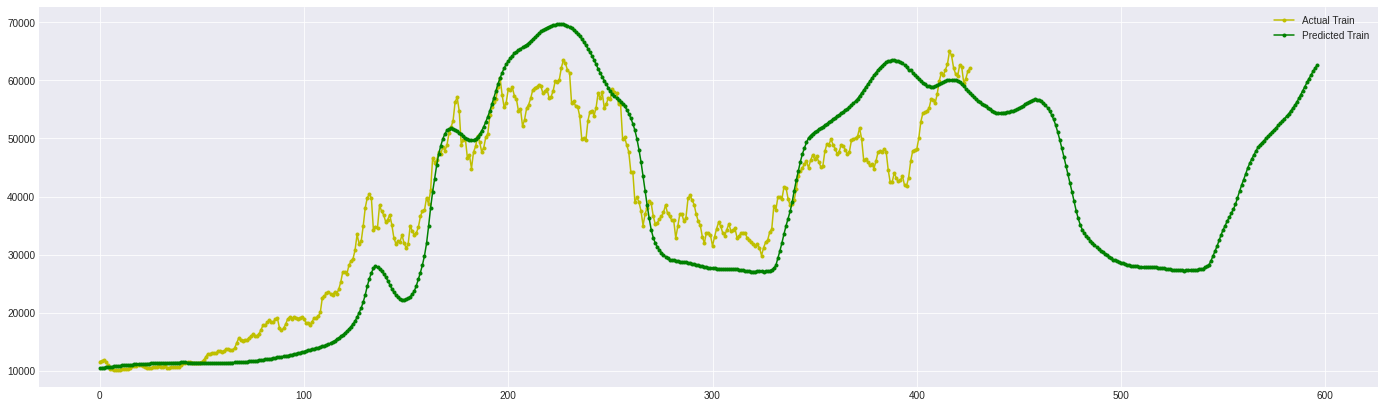

In [174]:
plt.figure(figsize=(24,7))

# log
plt.plot(np.exp(actual),'y', marker='.', label='Actual Train')
plt.plot(np.exp(predicted_btc_price), 'g', marker='.', label='Predicted Train')
# manoal
# plt.plot(actual,'y', marker='.', label='Actual Train')
# plt.plot(predicted_btc_price, 'g', marker='.', label='Predicted Train')


plt.legend()
plt.show()